[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled

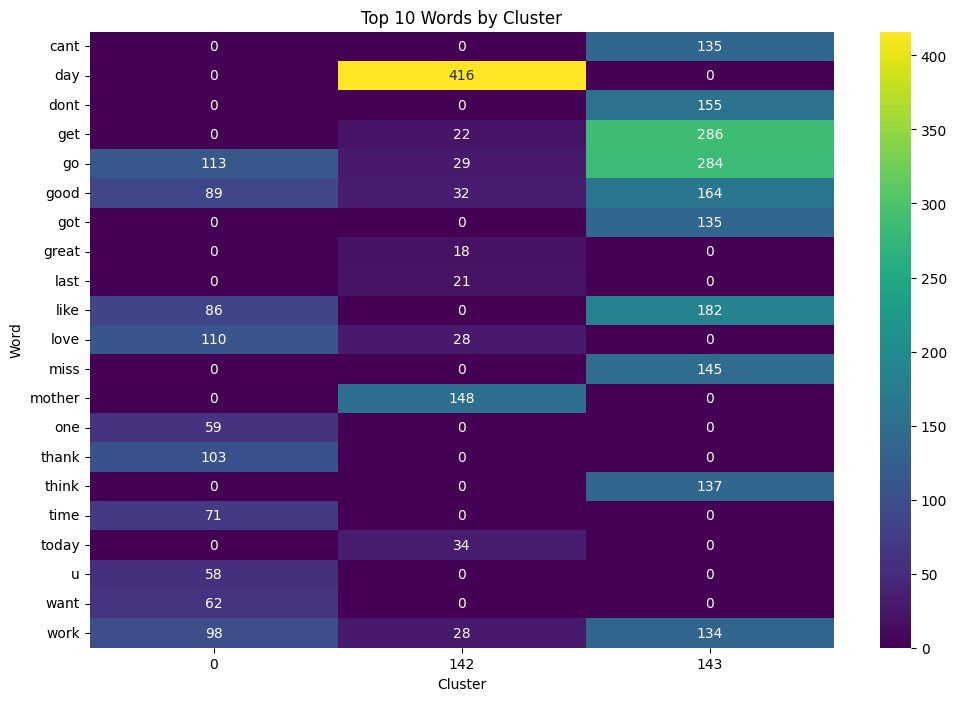


Top 10 palabras más repetidas por grupo:
Cluster    Word      0    142    143
0          cant    0.0    0.0  135.0
1           day    0.0  416.0    0.0
2          dont    0.0    0.0  155.0
3           get    0.0   22.0  286.0
4            go  113.0   29.0  284.0
5          good   89.0   32.0  164.0
6           got    0.0    0.0  135.0
7         great    0.0   18.0    0.0
8          last    0.0   21.0    0.0
9          like   86.0    0.0  182.0
10         love  110.0   28.0    0.0
11         miss    0.0    0.0  145.0
12       mother    0.0  148.0    0.0
13          one   59.0    0.0    0.0
14        thank  103.0    0.0    0.0
15        think    0.0    0.0  137.0
16         time   71.0    0.0    0.0
17        today    0.0   34.0    0.0
18            u   58.0    0.0    0.0
19         want   62.0    0.0    0.0
20         work   98.0   28.0  134.0

Cluster 0:
go       113
love     110
thank    103
work      98
good      89
like      86
time      71
want      62
one       59
u         58
Na

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_distances
from sklearn_extra.cluster import KMedoids
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import PorterStemmer
import string
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Descargar recursos de nltk
nltk.download('stopwords')
nltk.download('words')

# Inicializar el stemmer y el conjunto de palabras válidas
stemmer = PorterStemmer()
valid_words = set(words.words())

# Función de preprocesamiento del texto
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    stop_words = set(stopwords.words('english'))  # Conjunto de stop words en inglés
    text = text.lower()  # Convertir el texto a minúsculas
    text = ''.join([char for char in text if char not in string.punctuation])  # Eliminar la puntuación
    words_list = text.split()
    words_list = [word for word in words_list if word not in stop_words]  # Eliminar stop words
    words_list = [stemmer.stem(word) for word in words_list]  # Aplicar stemming
    words_list = [word for word in words_list if word in valid_words]  # Eliminar palabras no válidas
    text = ' '.join(words_list)
    return text

# Leer el archivo CSV con codificación ISO-8859-1 y seleccionar filas al azar
def read_csv(file_path, num_rows=None, seed=42):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if num_rows is not None:
        df = df.sample(n=num_rows, random_state=seed)
    return df

# Convertir los textos a vectores TF-IDF y obtener la palabra más representativa
def get_top_word(text, vectorizer):
    tfidf_matrix = vectorizer.transform([text])  # Transformar el texto en una matriz TF-IDF
    feature_array = np.array(vectorizer.get_feature_names_out())  # Obtener los nombres de las características (palabras)
    tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]  # Ordenar los puntajes TF-IDF en orden descendente
    top_word = feature_array[tfidf_sorting][0]  # Obtener la palabra con el puntaje más alto
    return top_word

# Obtener las palabras más frecuentes de cada cluster
def get_top_words_per_cluster(df, num_top_words=10):
    cluster_words = {}
    for cluster in df['cluster'].unique():
        words = ' '.join(df[df['cluster'] == cluster]['cleaned_text']).split()
        word_freq = pd.Series(words).value_counts().head(num_top_words)
        cluster_words[cluster] = word_freq[word_freq > 1]  # Asegurarse de que las palabras estén en el grupo
    return cluster_words

# Función principal para realizar el análisis PCA
def pca_analysis(file_path, num_rows=None, n_clusters=5, seed=42):
    # Leer el archivo CSV
    df = read_csv(file_path, num_rows, seed)
    
    # Asegurarse de que todas las entradas en la columna 'text' sean cadenas de texto
    df['text'] = df['text'].astype(str)
    
    # Preprocesar los textos
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    
    # Convertir los textos a vectores TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['cleaned_text']).toarray()
    
    # Obtener la palabra más representativa
    df['top_word'] = df['cleaned_text'].apply(lambda x: get_top_word(x, vectorizer))
    
    # Estandarizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Ajustar el número de clusters basado en el número de inliers
    n_clusters = min(n_clusters, X_scaled.shape[0])
    
    # Aplicar PCA con tres componentes
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(X_scaled)
    
    df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
    df_pca['top_word'] = df['top_word'].values
    
    # Calcular la matriz de distancias coseno
    distance_matrix = cosine_distances(X_scaled)
    
    # Clustering con K-Medoids y distancia de similitud coseno
    for attempt in range(10):
        kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=seed + attempt)
        clusters = kmedoids.fit_predict(distance_matrix)
        if len(set(clusters)) == n_clusters:
            break
    
    df_pca['cluster'] = clusters
    df['cluster'] = clusters
    
    # Agregar etiquetas numéricas a cada punto en el gráfico
    df_pca['label'] = df_pca.index
    
    # Visualización interactiva en 3D con plotly
    fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='cluster', title='PCA of Tweet Data in 3D', color_continuous_scale=px.colors.sequential.Rainbow,  
                        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
                        hover_name='top_word')
    
    fig.update_traces(marker=dict(size=3))  # Hacer los puntos más pequeños
    fig.update_layout(scene=dict(
                        xaxis_title='Principal Component 1',
                        yaxis_title='Principal Component 2',
                        zaxis_title='Principal Component 3'),
                      margin=dict(l=0, r=0, b=0, t=40))
    
    # Guardar el gráfico interactivo en un archivo HTML
    fig.write_html("pca_tweet_data.html")
    
    fig.show()
    
    # Obtener y mostrar las palabras más frecuentes por cluster
    top_words_dict = get_top_words_per_cluster(df)
    top_words_df = pd.DataFrame(top_words_dict).fillna(0)
    
    # Formatear la tabla de palabras agrupadas
    top_words_df.index.name = 'Word'
    top_words_df.columns.name = 'Cluster'
    top_words_df.reset_index(inplace=True)
    
    # Mostrar la tabla de palabras agrupadas
    plt.figure(figsize=(12, 8))
    sns.heatmap(top_words_df.set_index('Word'), annot=True, fmt='g', cmap='viridis')
    plt.title('Top 10 Words by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Word')
    plt.show()
    
    # Exportar la tabla a un archivo Excel
    top_words_df.to_excel("top_words_by_cluster.xlsx", index=False)
    
    return top_words_df, top_words_dict

# Ejemplo de uso
file_path = 'C:/Users/nicol/OneDrive/MIA/Cursos/Aprendizaje Sup/Proyecto de Aplicacion/REPO GITHUB/proyecto-final-machine-learning/dataset/train.csv'  # Ruta actualizada del archivo CSV
num_rows = 5000  # Número de filas a considerar para el análisis, None para usar todas las filas
n_clusters = 144  # Número de clusters
seed = 42  # Semilla para la selección aleatoria

top_words_df, top_words_dict = pca_analysis(file_path, num_rows, n_clusters, seed)

# Mostrar la tabla de palabras agrupadas
print("\nTop 10 palabras más repetidas por grupo:")
print(top_words_df)

# Imprimir el listado de los grupos por separado
for cluster, words in top_words_dict.items():
    print(f"\nCluster {cluster}:")
    print(words)
